In [1]:
%matplotlib inline
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

##### Note

Because of the skip connections between the down-sampling and up-sampling sides of the network, input image size must be divisible by 32 (2^5). This is because of the max pooling / transpose convolution layers on the down-sampling and up-sampling branch of the network respectively. There are 5 of these units each with 2x2 kernel size and stride 2. Thus, the input must be divisible by 2^5 to ensure the outputs along the down-sampling side of the net can concatenate with the up-sampling side.

In [3]:
# the size of the images in the dataset
target_size = (720, 960)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (512, 640)
# fine_crop = (480, 640)

# Coarse Tuning

train on random crops of size 224 x 224 (images are also random flipped about x and y axis)

In [4]:
generators, transformer = camvid.data_generators(target_size=target_size, crop_size=coarse_crop)

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


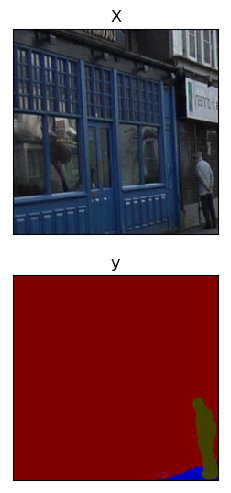

In [5]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = transformer.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [6]:
# get the size of the one-hot vectors from the transformer
num_labels = len(transformer)
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), num_labels,
    label_names=transformer.labels,
    learning_rate=1e-3,
)

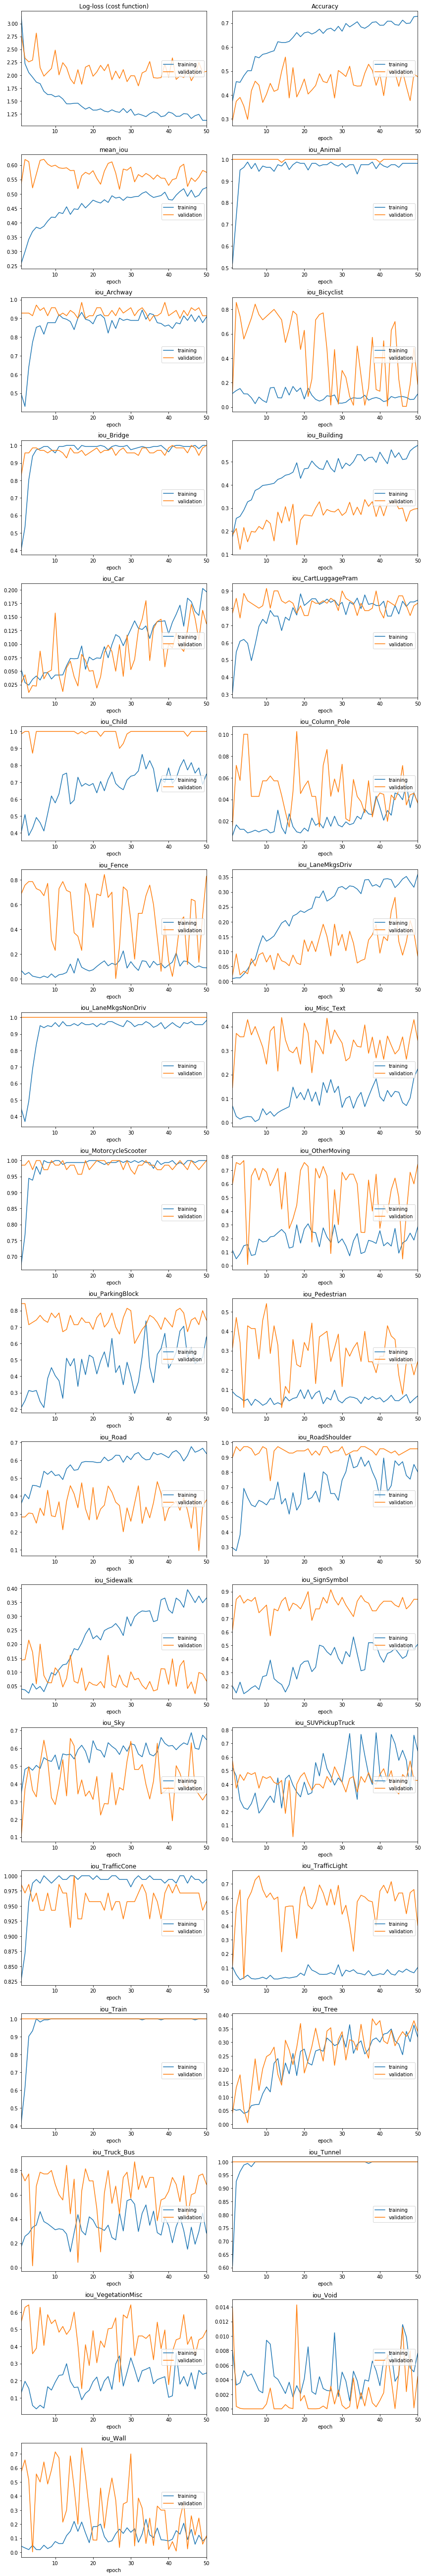

In [7]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=int(491 / 3),
    validation_data=generators['validation'],
    validation_steps=int(210 / 3),
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [8]:
history_to_results(history)

,train,val
acc,0.728145,0.476104
Animal,0.981557,1.000000
Archway,0.907787,0.914286
Bicyclist,0.107173,0.185965
Bridge,1.000000,1.000000
Building,0.570667,0.297297
Car,0.196439,0.137479
CartLuggagePram,0.846311,0.828571
Child,0.747984,1.000000
Column_Pole,0.036941,0.036962


In [9]:
X, y = next(generators['training'])
p = model.predict(X)

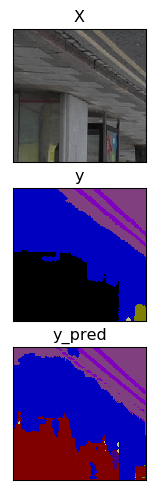

In [10]:
camvid.plot(X=X[0], y=transformer.unmap(y)[0], y_pred=transformer.unmap(p)[0])

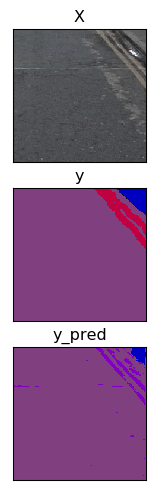

In [11]:
camvid.plot(X=X[1], y=transformer.unmap(y)[1], y_pred=transformer.unmap(p)[1])

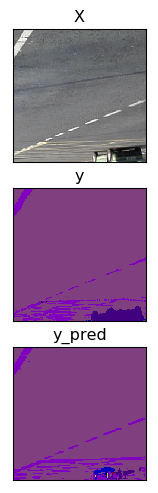

In [12]:
camvid.plot(X=X[2], y=transformer.unmap(y)[2], y_pred=transformer.unmap(p)[2])

In [13]:
X, y = next(generators['validation'])
p = model.predict(X)

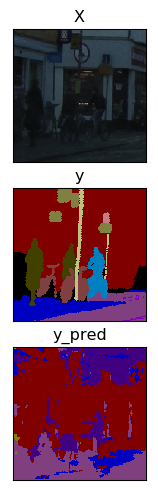

In [14]:
camvid.plot(X=X[0], y=transformer.unmap(y)[0], y_pred=transformer.unmap(p)[0])

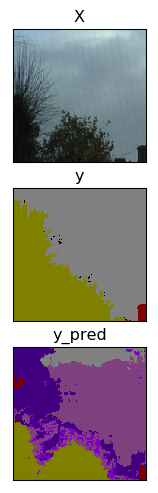

In [15]:
camvid.plot(X=X[1], y=transformer.unmap(y)[1], y_pred=transformer.unmap(p)[1])

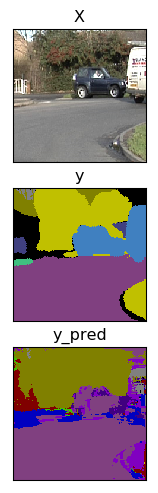

In [16]:
camvid.plot(X=X[2], y=transformer.unmap(y)[2], y_pred=transformer.unmap(p)[2])

## Save Model

In [17]:
# serialize weights to HDF5
model.save_weights('models/tiramisu103-coarse.h5')

# Clear Session

remove the current model from memory.

In [18]:
from keras import backend as K
K.clear_session()

# Fine Tuning

Train on larger crops (because the full size image results in a OutOfMemory error on the P100). max queue size of 
the fit generator is also reduced (resulting in a slowdown) to accomodate these larger images. The original authors
were able to train on full size images because the CamVid 11 had a smaller maximum size than the CamVid 32.

In [19]:
generators, transformer = camvid.data_generators(target_size=target_size, crop_size=fine_crop, batch_size=1)

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


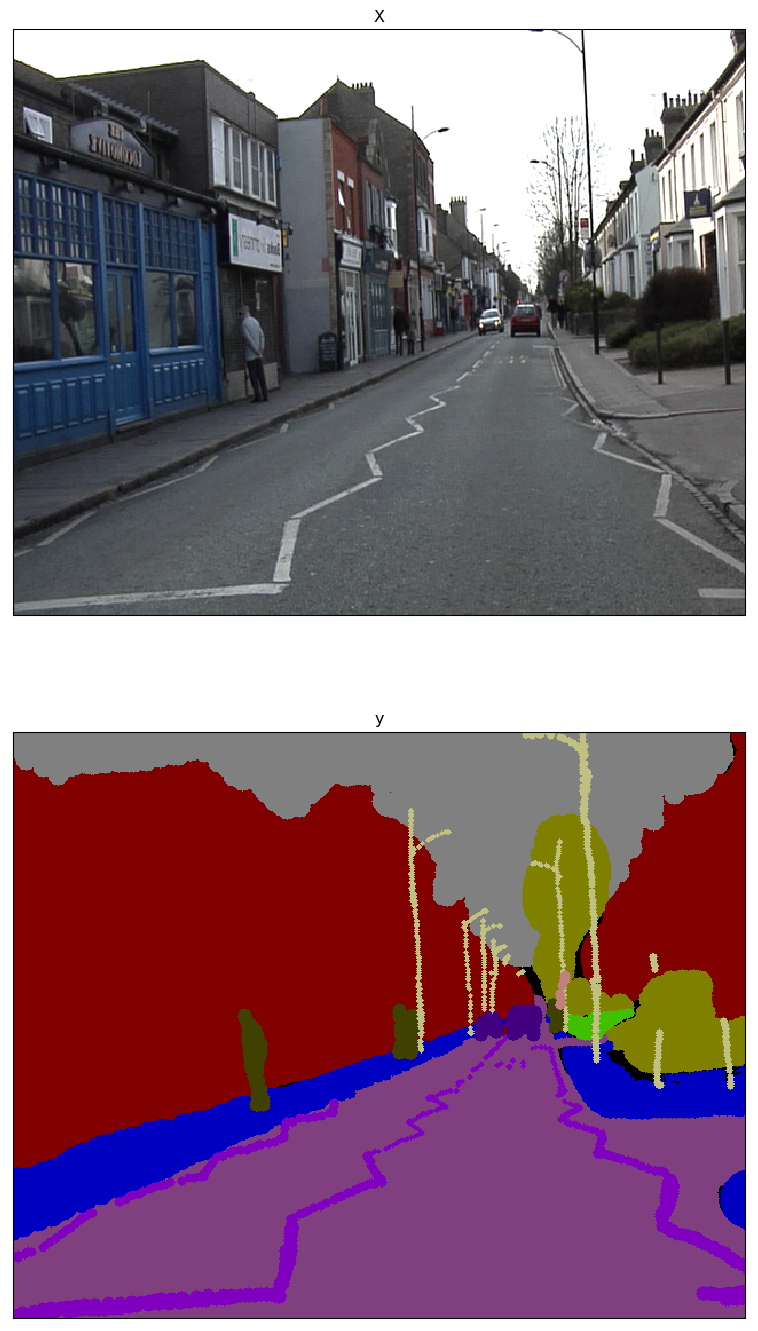

In [20]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = transformer.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [21]:
# # get the size of the one-hot vectors from the transformer
num_labels = len(transformer)
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), num_labels,
    label_names=transformer.labels,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/tiramisu103-coarse.h5')

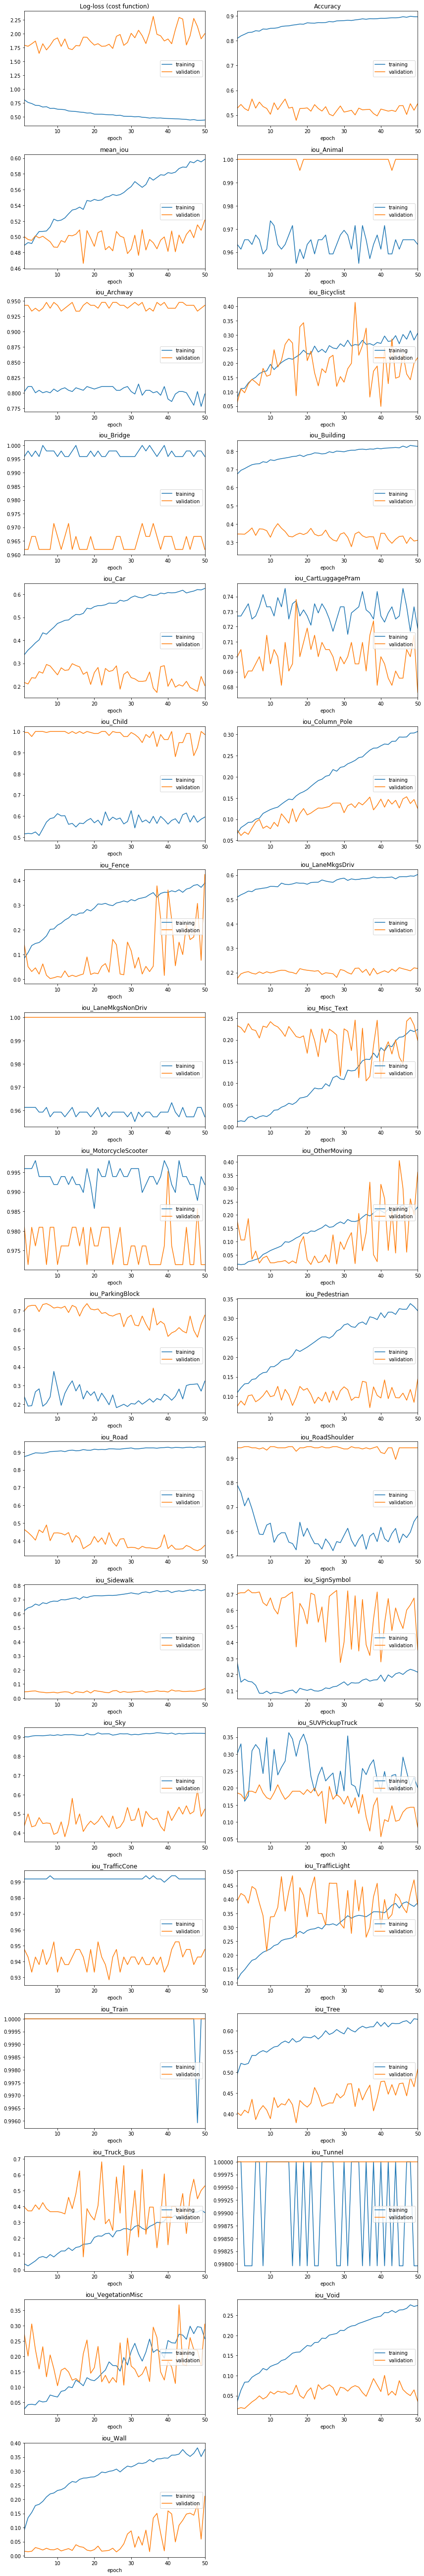

In [22]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=491,
    validation_data=generators['validation'],
    validation_steps=210,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=50),
        PlotLossesKeras(),
    ],
    verbose=0,
    max_queue_size=1
)

In [23]:
history_to_results(history)

,train,val
acc,0.896648,0.546369
Animal,0.963340,1.000000
Archway,0.798506,0.942857
Bicyclist,0.306020,0.220589
Bridge,0.995927,0.961905
Building,0.826583,0.310521
Car,0.625598,0.203755
CartLuggagePram,0.718941,0.676190
Child,0.595707,0.985714
Column_Pole,0.307140,0.125378


In [24]:
X, y = next(generators['training'])
p = tune_model.predict(X)

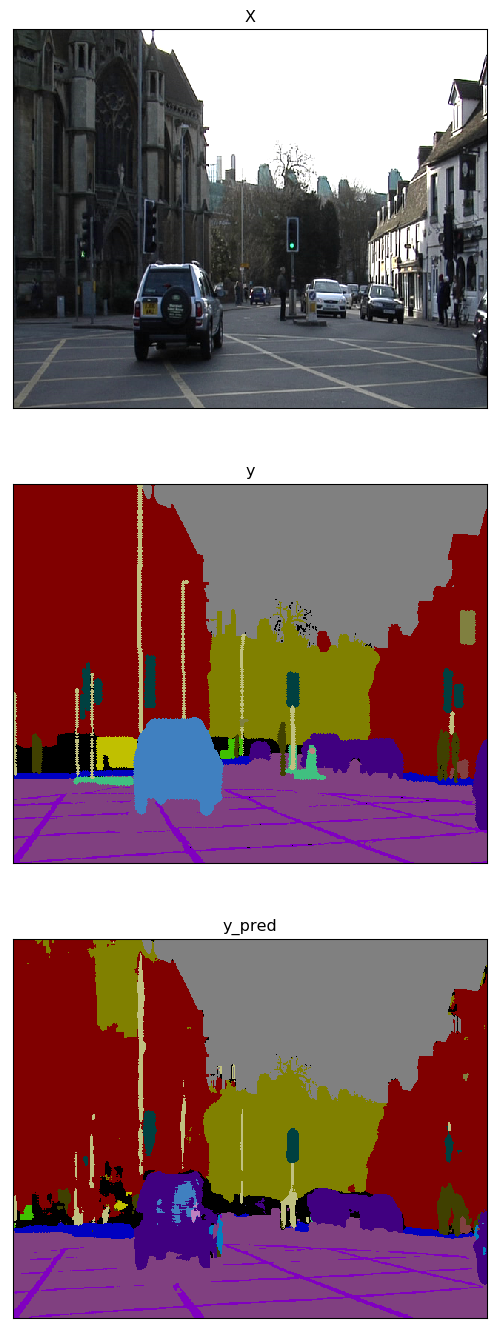

In [25]:
camvid.plot(X=X[0], y=transformer.unmap(y)[0], y_pred=transformer.unmap(p)[0])

In [26]:
X, y = next(generators['validation'])
p = tune_model.predict(X)

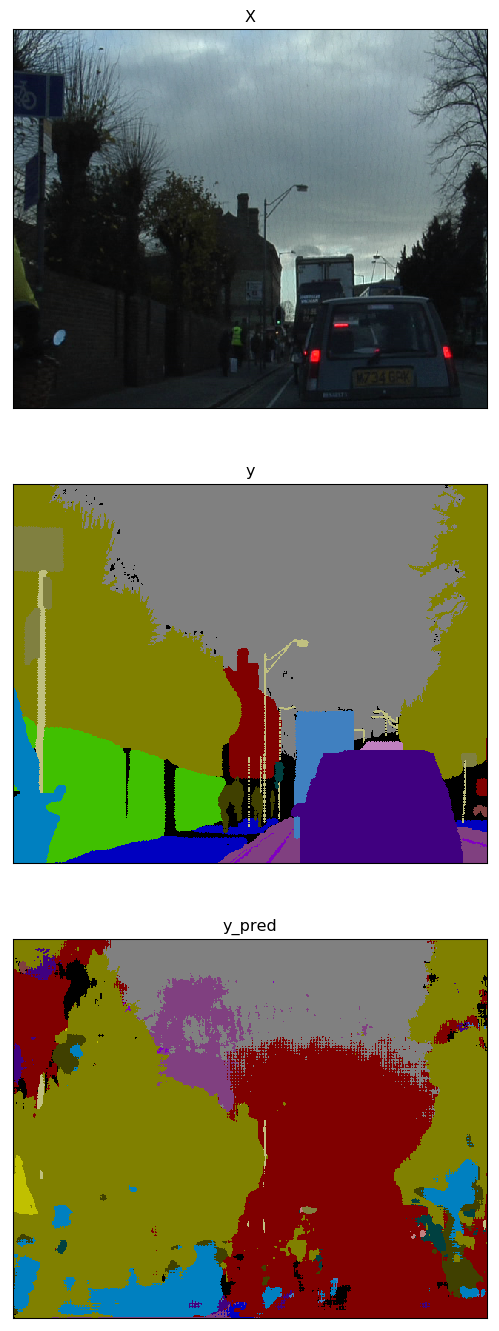

In [27]:
camvid.plot(X=X[0], y=transformer.unmap(y)[0], y_pred=transformer.unmap(p)[0])

## Save Model

In [28]:
# serialize weights to HDF5
tune_model.save_weights('models/tiramisu103-fine.h5')